# Задание 3

## Построение более сложной модели с подбором гиперпараметров

Будем использовать `catboost`

In [ ]:
%pip install catboost

In [1]:
import optuna
from catboost import CatBoostClassifier

In [5]:
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

In [3]:
# заного загружаем набор данных
csv_file = next((f for f in os.listdir() if f.endswith(".csv")), None)
if not csv_file:
    print("файл не найден.")

df = pd.read_csv(csv_file)

In [6]:
# подготовим данные
df_final = pd.concat(
    [
        df.select_dtypes(include=["number"]),
        df[
            [
                col
                for col in df.select_dtypes(include=["object"])
                if df[col].nunique() < 5
            ]
        ],
    ],
    axis=1,
)

categorical_cols = df_final.select_dtypes(include=["object"]).columns
df_encoded = pd.get_dummies(df_final, columns=categorical_cols, drop_first=True)

# выберем таргет
X = df_encoded.drop(columns="Churn_Yes")
y = df_encoded["Churn_Yes"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=52, stratify=y
)
print(f"разбиение train/test: {X_train.shape[0]} | {X_test.shape[0]}")

разбиение train/test: 4930 | 2113


#### Подбор гиперпараметров, используя `scikit-learn`

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'iterations': [100, 200, 500, 1000],
    'depth': [2, 4, 6, 10, 15],
    'learning_rate': [.1, .01, .001, .0001],
    'l2_leaf_reg': [1, 3, 5, 10],
    'border_count': [32, 64, 128, 256]
}

catboost_model = CatBoostClassifier(verbose=0, random_state=52)

random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_dist,
    scoring='f1',
    n_iter=20,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Лучшие гиперпараметры:", random_search.best_params_)

# осторожно - 9.6 минут вычислений.

подбор гиперпараметров используя `RandomizedSearchCV` выдал:

*Лучшие гиперпараметры: {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 200, 'depth': 6, 'border_count': 64}*

#### Подбор гиперпараметров, используя `optuna`

In [17]:
from sklearn.model_selection import cross_val_score

def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 2, 15),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 256),
        'loss_function': 'Logloss'
    }

    catboost_model = CatBoostClassifier(**param, verbose=0, random_state=52)
    
    score = cross_val_score(catboost_model, X_train, y_train, scoring='f1', cv=5).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Лучшие гиперпараметры:", study.best_params)

# осторожно - 49.5 минут вычислений.

[I 2024-10-20 12:59:12,594] A new study created in memory with name: no-name-a60f5a87-4e23-40a3-82b8-d76ebfacc067
/var/folders/9s/13gnpt8j4l98lnc5568wwxf00000gn/T/ipykernel_29799/3977339110.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),
/var/folders/9s/13gnpt8j4l98lnc5568wwxf00000gn/T/ipykernel_29799/3977339110.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1, 10),
[I 2024-10-20 13:00:02,346] Trial 0 finished with value: 0.5620448229553812 and parameters: {'iterations': 696, 'depth': 11, 'learning_rate': 0.0019750692296880757, 'l2_lea

Лучшие гиперпараметры: {'iterations': 200, 'depth': 8, 'learning_rate': 0.05029485480195561, 'l2_leaf_reg': 1.3055224419729419, 'border_count': 230}


подбор гиперпараметров с optuna выдал:

*Лучшие гиперпараметры: {'iterations': 200, 'depth': 8, 'learning_rate': 0.05029485480195561, 'l2_leaf_reg': 1.3055224419729419, 'border_count': 230}*

In [8]:
from sklearn.metrics import f1_score, roc_auc_score

In [22]:
best_params = random_search.best_params_

best_cb = CatBoostClassifier(**best_params, random_state=52, verbose=0)
best_cb.fit(X_train, y_train)
y_pred = best_cb.predict(X_test)
print(
    f"f1: {f1_score(y_test, y_pred):.4f}; ROC-AUC: {roc_auc_score(y_test, best_cb.predict_proba(X_test)[:, 1]):.4f}"
)

f1: 0.5682; ROC-AUC: 0.8416


## Интерпритация модели

оценим, какие признаки оказывают наибольшее влияние при работе CatBoost

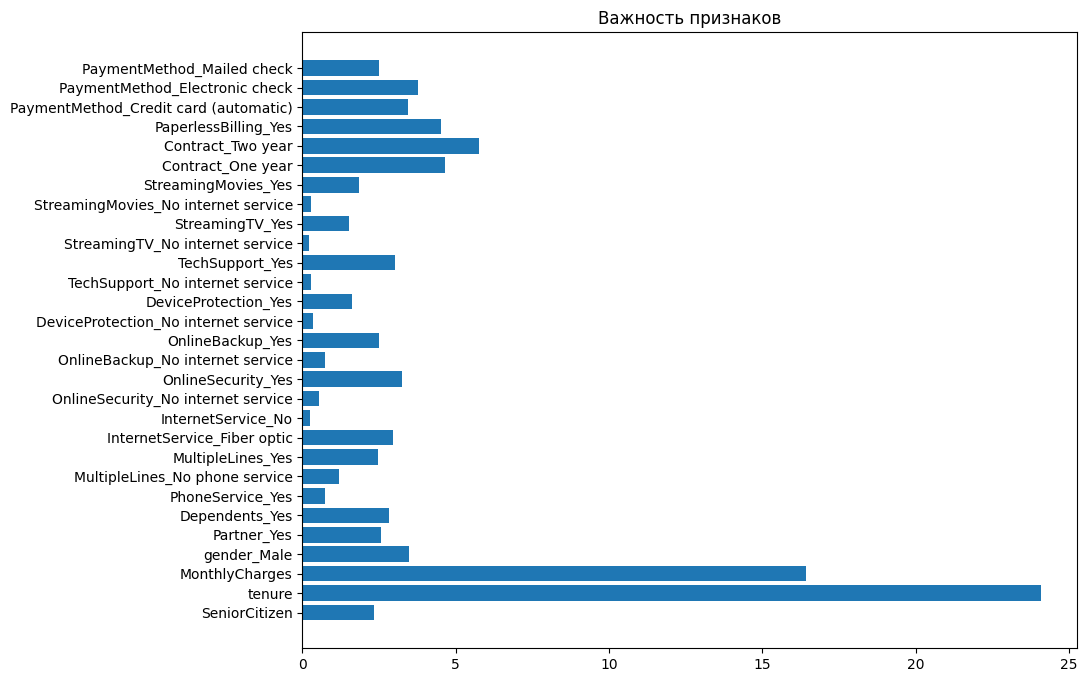

In [25]:
fimportances = best_cb.get_feature_importance()
fnames = X_train.columns

plt.figure(figsize=(10, 8))
plt.barh(fnames, fimportances)
plt.title("Важность признаков")
plt.show()

по графику заметно, что больше всего на модель влияют tenure(это наш таргет, поэтому очевидно), затем месячная плата, заключены ли 1-2х летние контракты с клиентом.

умеренное влияние оказывают способы оплаты, пакет интернет услуг и, на удивление, наличие партнера/семьи.